# AutoencoderKL

This demo is a toy example of how to use MONAI's AutoencoderKL. In particular, it uses
the Autoencoder with a Kullback-Leibler regularisation as implemented by Rombach et. al [1].

[1] Rombach et. al - ["High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/pdf/2112.10752.pdf)



This tutorial was based on:

[Registration Mednist](https://github.com/Project-MONAI/tutorials/blob/main/2d_registration/registration_mednist.ipynb)

[Mednist Tutorial](https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)




In [1]:
# TODO: Add buttom with "Open with Colab"

## Set up environment using Colab

In [2]:
!pip install -q "monai-weekly[tqdm]==1.1.dev2239"
!pip install -q matplotlib
!pip install -q einops
%matplotlib inline

In [3]:
%cd /mnt_homes/home4T7/jdafflon/GenerativeModels

/mnt_homes/home4T7/jdafflon/GenerativeModels


## Setup imports

In [4]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from tqdm import tqdm

from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, PatchDiscriminator

print_config()

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.dev2239
Numpy version: 1.23.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, plea

In [5]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not
specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp6tm79s8a


### Download the training set

In [7]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)

MedNIST.tar.gz: 59.0MB [00:00, 94.1MB/s]                                                                                      

2022-12-04 15:10:28,282 - INFO - Downloaded: /tmp/tmp6tm79s8a/MedNIST.tar.gz


2022-12-04 15:10:28,385 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-12-04 15:10:28,386 - INFO - Writing into directory: /tmp/tmp6tm79s8a.


Loading dataset: 100%|████████████████████████████████████████████████████████████████| 47164/47164 [00:17<00:00, 2630.50it/s]


### Visualise examples from the training set

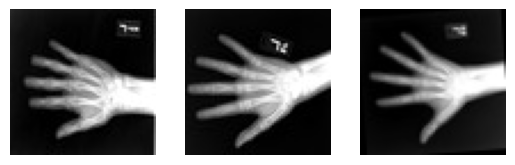

In [8]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

### Download the validation set

In [9]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)

2022-12-04 15:10:52,458 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-12-04 15:10:52,459 - INFO - File exists: /tmp/tmp6tm79s8a/MedNIST.tar.gz, skipped downloading.
2022-12-04 15:10:52,460 - INFO - Non-empty folder exists in /tmp/tmp6tm79s8a/MedNIST, skipped extracting.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████| 5895/5895 [00:02<00:00, 2716.34it/s]


## Define the network

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [11]:
model = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=64,
    latent_channels=3,
    ch_mult=(1, 2, 2),
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
model = model.to(device)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (adn): ADN(
      (N): Batch

In [12]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

optimizer_g = torch.optim.Adam(model.parameters(), 1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Training

It takes ~1hr to train the model

In [13]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        reconstruction, z_mu, z_sigma = model(images)

        recons_loss = F.l1_loss(reconstruction.float(), images.float())
        p_loss = perceptual_loss(reconstruction.float(), images.float())
        kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
        loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

        if epoch > autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g += adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        if epoch > autoencoder_warm_up_n_epochs:
            optimizer_d.zero_grad(set_to_none=True)

            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

            loss_d.backward()
            optimizer_d.step()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                optimizer_g.zero_grad(set_to_none=True)

                reconstruction, z_mu, z_sigma = model(images)
                # Get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()


Epoch 9: 100%|██████████████████| 125/125 [00:28<00:00,  4.31it/s, recons_loss=0.024, gen_loss=0, disc_loss=0]


epoch 10 val loss: 0.0244


Epoch 19: 100%|█████████| 125/125 [00:31<00:00,  3.93it/s, recons_loss=0.0209, gen_loss=0.32, disc_loss=0.232]


epoch 20 val loss: 0.0227


Epoch 29: 100%|████████| 125/125 [00:31<00:00,  3.94it/s, recons_loss=0.0186, gen_loss=0.305, disc_loss=0.236]


epoch 30 val loss: 0.0199


Epoch 39: 100%|█████████| 125/125 [00:31<00:00,  3.93it/s, recons_loss=0.0186, gen_loss=0.329, disc_loss=0.23]


epoch 40 val loss: 0.0207


Epoch 49: 100%|████████| 125/125 [00:31<00:00,  3.92it/s, recons_loss=0.0182, gen_loss=0.365, disc_loss=0.223]


epoch 50 val loss: 0.0196


Epoch 59: 100%|██████████| 125/125 [00:31<00:00,  3.92it/s, recons_loss=0.019, gen_loss=0.45, disc_loss=0.192]


epoch 60 val loss: 0.0207


Epoch 69: 100%|██████████| 125/125 [00:31<00:00,  3.92it/s, recons_loss=0.019, gen_loss=0.47, disc_loss=0.174]


epoch 70 val loss: 0.0216


Epoch 79: 100%|████████| 125/125 [00:31<00:00,  3.92it/s, recons_loss=0.0195, gen_loss=0.508, disc_loss=0.177]


epoch 80 val loss: 0.0212


Epoch 89: 100%|████████| 125/125 [00:31<00:00,  3.93it/s, recons_loss=0.0193, gen_loss=0.545, disc_loss=0.162]


epoch 90 val loss: 0.0218


Epoch 99: 100%|█████████| 125/125 [00:31<00:00,  3.93it/s, recons_loss=0.0198, gen_loss=0.634, disc_loss=0.13]


epoch 100 val loss: 0.0239


## Evaluate the training
### Visualise the loss

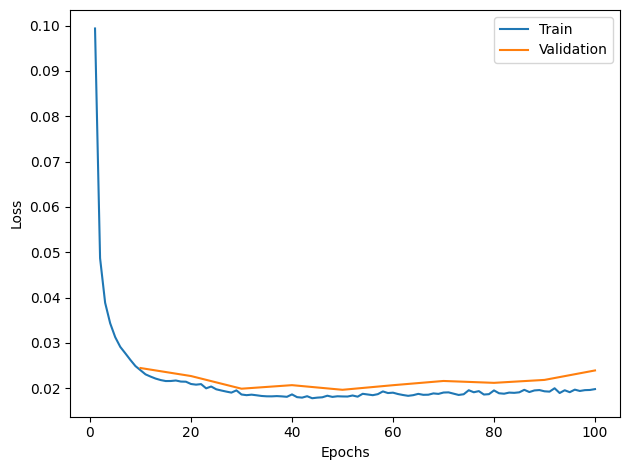

In [14]:
plt.figure()
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_recon_loss_list, label="Train")
plt.plot(val_samples, val_recon_epoch_loss_list, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

### Visualise some reconstruction images

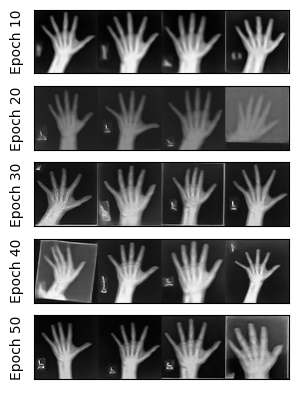

In [15]:
# Get the first 5 examples to plot
n_evaluations = 5
fig, ax = plt.subplots(nrows=n_evaluations, ncols=1, sharey=True)
for image_n in range(n_evaluations):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * n_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

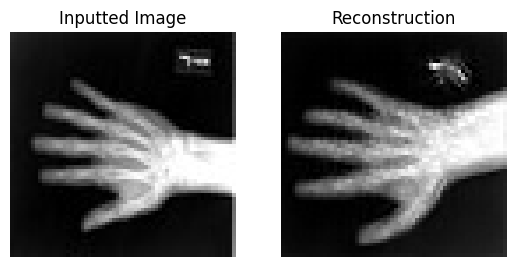

In [16]:
img = check_data["image"][0]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(check_data["image"][0, 0, ...], vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")
ax[1].imshow(reconstruction[0, 0, ...].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

### Clean-up data directory

In [17]:
if directory is None:
    shutil.rmtree(root_dir)